In [ ]:
import os
import numpy as np
import time


In [ ]:
import rosbag
from cv_bridge import CvBridge, CvBridgeError
img_bridge = CvBridge()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from bs_imu import bs_imu
from bs_imu import bs_ekf

from bs_img import bs_img_real
from bs_img.bs_cfg_real_1m import *

In [ ]:
# input_bag = rosbag.Bag(f"../../../bag/2024-04-01-03-16-55_noimg.bag")
input_bag = rosbag.Bag(f"../../../bag/2023-07-22-21-38-11.bag")

In [ ]:
pose_calc_enu_lf = []
pose_calc_enu_sf = []
pose_ref_enu_lf = []
pose_ref_enu_sf = []

lf_input = []
sf_input = []


mav_pose = None
mav_quat = None
mav_R_be = None
mav_lin_vel = None
mav_ang_vel = None

pos_init_done = False
vel_init_done = False
acc_init_done = False


for topic, msg, t in input_bag.read_messages():
    if topic == "/mavros/global_position/local":
        mav_quat = [
            msg.pose.pose.orientation.w,
            msg.pose.pose.orientation.x,
            msg.pose.pose.orientation.y,
            msg.pose.pose.orientation.z,
        ]
        mav_pose = [
            msg.pose.pose.position.x,
            msg.pose.pose.position.y,
            msg.pose.pose.position.z,
        ]
        mav_R_be = bs_imu.quat_to_matrix(mav_quat)
        if not pos_init_done:
            pos_init_done = True
    
    
    if topic == "/mavros/local_position/velocity_local":
        local_lin_vel = [
            msg.twist.linear.x,
            msg.twist.linear.y,
            msg.twist.linear.z,
        ]
        local_ang_vel = [
            msg.twist.angular.x,
            msg.twist.angular.y,
            msg.twist.angular.z,
        ]

        if not vel_init_done:
            vel_init_done = True
            
    if topic == "/mavros/imu/data":
        mav_lin_acc = [
            msg.linear_acceleration.x,
            msg.linear_acceleration.y,
            msg.linear_acceleration.z,
        ]
        R_be = bs_imu.quat_to_matrix([
            msg.orientation.w,
            msg.orientation.x,
            msg.orientation.y,
            msg.orientation.z,
        ])
        lin_acc = np.dot(R_be.T,mav_lin_acc)
        if not acc_init_done:
            acc_init_done = True
            
    if topic == "/image_ksj_lf":
        if not (pos_init_done and vel_init_done and acc_init_done):
            continue
        img_gray = img_bridge.imgmsg_to_cv2(msg, msg.encoding)
        gt_pts,_ = bs_img_real.img_to_pts(img_gray)
        result_dict = bs_img_real.solve_plane_pt(gt_pts,plane_real_ptL=plane_real_ptL,cam_K=camK_lf)
        
        
        t_vec = result_dict["t_vec"]
        r_vec = result_dict["t_vec"]
        pose_calc = np.dot(mav_R_be.T,R_bc.dot(t_vec))
        quat_calc = bs_imu.rot_vec_to_quat(r_vec)
        
        
        pose_calc_enu_lf.append(pose_calc)
        pose_ref_enu_lf.append(mav_pose)
        
        input_dict = {}
        input_dict["timestamp"] = t.to_sec()
        input_dict["lin_acc"] = lin_acc
        input_dict["angle_vel"] = local_ang_vel
        input_dict["lin_vel"] = local_lin_vel
        input_dict["quat_be"] = mav_quat
        input_dict["quat_calc"] = quat_calc
        lf_input.append(input_dict)
        
        
    if topic == "/image_ksj_sf":
        if not (pos_init_done and vel_init_done and acc_init_done):
            continue
        
        img_gray = img_bridge.imgmsg_to_cv2(msg, msg.encoding)
        gt_pts,_ = bs_img_real.img_to_pts(img_gray)
        result_dict = bs_img_real.solve_plane_pt(gt_pts,plane_real_ptL=plane_real_ptL,cam_K=camK_sf)


        t_vec = result_dict["t_vec"]
        r_vec = result_dict["t_vec"]
        pose_calc = np.dot(mav_R_be.T,R_bc.dot(t_vec))
        quat_calc = bs_imu.rot_vec_to_quat(r_vec)
        
        
        pose_calc_enu_sf.append(pose_calc)
        pose_ref_enu_sf.append(mav_pose)
        
        input_dict = {}
        input_dict["timestamp"] = t.to_sec()
        input_dict["lin_acc"] = lin_acc
        input_dict["angle_vel"] = local_ang_vel
        input_dict["lin_vel"] = local_lin_vel
        input_dict["quat_be"] = mav_quat
        input_dict["quat_calc"] = quat_calc
        sf_input.append(input_dict)

            
    # if topic == "/bs_debuger/result/lf":
    #     if not init_done:
    #         continue
        
    #     t_vec = [
    #         msg.translation.x,
    #         msg.translation.y,
    #         msg.translation.z,
    #     ]
    #     R_ct = bs_imu.quat_to_matrix([
    #         msg.rotation.w,
    #         msg.rotation.x,
    #         msg.rotation.y,
    #         msg.rotation.z,
    #     ])

    #     pose_calc = np.dot(mav_R_be.T,R_bc.dot(t_vec))
    #     pose_calc_enu.append(pose_calc)
    #     pose_ref_enu.append(mav_pose)

pose_calc_enu_lf = np.array(pose_calc_enu_lf)
pose_calc_enu_sf = np.array(pose_calc_enu_sf)
pose_ref_enu_lf = np.array(pose_ref_enu_lf)
pose_ref_enu_sf = np.array(pose_ref_enu_sf)

In [ ]:
# pose_calc_enu_lf[:,0] = -pose_calc_enu_lf[:,0]
pose_calc_enu_sf[:,0] = -pose_calc_enu_sf[:,0]

In [ ]:
start_idx = 500
end_idx = -1
pose_gt_lf = pose_ref_enu_lf
pose_direct_lf = pose_calc_enu_lf - np.array([0,27,0.4])

fig, axs = plt.subplots(2, 3,figsize=(16, 7.8))
LABEL = "NED"
for i in range(3):
    axs[0,i].plot(pose_gt_lf[start_idx:end_idx,i],label="gt")
    axs[0,i].plot(pose_direct_lf[start_idx:end_idx,i],label="direct")
    # axs[0,i].plot(pose_ekf[start_idx:end_idx,i],label="ekf")

    axs[0,i].set_title(f"Relative Positioning at {LABEL[i]} Axis")
    axs[0,i].set_xlabel("time [s]")
    axs[0,i].set_ylabel(f"{LABEL[i]} [m]")
    # axs[0,i].ylim([0,300])
    axs[0,i].legend()
for i in range(3):
    # axs[1,i].plot(pose_gt_lf[start_idx:end_idx,i],label="gt")
    axs[1,i].plot(pose_direct_lf[start_idx:end_idx,i] - pose_gt_lf[start_idx:end_idx,i],label="direct")
    # axs[1,i].plot(pose_ekf[start_idx:end_idx,i] - pose_gt_lf[start_idx:end_idx,i],label="ekf")

    axs[1,i].set_title(f"Err at {LABEL[i]} Axis")
    axs[1,i].set_xlabel("time [s]")
    axs[1,i].set_ylabel(f"{LABEL[i]} [m]")
    axs[1,i].legend()
fig.tight_layout()
# plt.savefig("sitl-pose.pdf")

In [ ]:
start_idx = 500
end_idx = -1
pose_gt_sf = pose_ref_enu_sf 
pose_direct_sf = pose_calc_enu_sf - np.array([-1.6,28,0.4])

fig, axs = plt.subplots(2, 3,figsize=(16, 7.8))
LABEL = "NED"
for i in range(3):
    axs[0,i].plot(pose_gt_sf[start_idx:end_idx,i],label="gt")
    axs[0,i].plot(pose_direct_sf[start_idx:end_idx,i],label="direct")
    # axs[0,i].plot(pose_ekf[start_idx:end_idx,i],label="ekf")

    axs[0,i].set_title(f"Relative Positioning at {LABEL[i]} Axis")
    axs[0,i].set_xlabel("time [s]")
    axs[0,i].set_ylabel(f"{LABEL[i]} [m]")
    # axs[0,i].ylim([0,300])
    axs[0,i].legend()
for i in range(3):
    # axs[1,i].plot(pose_gt_sf[start_idx:end_idx,i],label="gt")
    axs[1,i].plot(pose_direct_sf[start_idx:end_idx,i] - pose_gt_sf[start_idx:end_idx,i],label="direct")
    # axs[1,i].plot(pose_ekf[start_idx:end_idx,i] - pose_gt_sf[start_idx:end_idx,i],label="ekf")

    axs[1,i].set_title(f"Err at {LABEL[i]} Axis")
    axs[1,i].set_xlabel("time [s]")
    axs[1,i].set_ylabel(f"{LABEL[i]} [m]")
    axs[1,i].legend()
fig.tight_layout()
# plt.savefig("sitl-pose.pdf")

In [ ]:
start_idx = 500
end_idx = 2800

fuse_idx = 2200
fuse_len_hf = 100
weight_hf = 1-np.exp(-np.arange(fuse_len_hf)/(fuse_len_hf/2))/2
weight = np.concatenate([np.flip(1-weight_hf),weight_hf])

pose_direct_fuse = (
    (pose_direct_lf[fuse_idx-fuse_len_hf:fuse_idx+fuse_len_hf].T*np.array(1-weight)).T +
    (pose_direct_sf[fuse_idx-fuse_len_hf:fuse_idx+fuse_len_hf].T*np.array(weight)).T 
)

pose_gt_fix = np.array([0,25,0]) + pose_ref_enu_lf 
pose_direct_fix = np.array([0,25,0]) + np.concatenate([
    pose_direct_lf[:fuse_idx-fuse_len_hf],
    pose_direct_fuse,
    pose_direct_sf[fuse_idx+fuse_len_hf:]
])



fig, axs = plt.subplots(2, 3,figsize=(16, 7.8))
LABEL = "NED"
for i in range(3):
    axs[0,i].plot(pose_gt_fix[start_idx:end_idx,i],label="gt")
    axs[0,i].plot(pose_direct_fix[start_idx:end_idx,i],label="direct")
    # axs[0,i].plot(pose_ekf[start_idx:end_idx,i],label="ekf")

    axs[0,i].set_title(f"Relative Positioning at {LABEL[i]} Axis")
    axs[0,i].set_xlabel("time [s]")
    axs[0,i].set_ylabel(f"{LABEL[i]} [m]")
    # axs[0,i].ylim([0,300])
    axs[0,i].legend()
for i in range(3):
    # axs[1,i].plot(pose_gt_fix[start_idx:end_idx,i],label="gt")
    axs[1,i].plot(pose_direct_fix[start_idx:end_idx,i] - pose_gt_fix[start_idx:end_idx,i],label="direct")
    # axs[1,i].plot(pose_ekf[start_idx:end_idx,i] - pose_gt_fix[start_idx:end_idx,i],label="ekf")

    axs[1,i].set_title(f"Err at {LABEL[i]} Axis")
    axs[1,i].set_xlabel("time [s]")
    axs[1,i].set_ylabel(f"{LABEL[i]} [m]")
    axs[1,i].legend()
fig.tight_layout()

In [ ]:
g = 9.8015

In [ ]:
pose_direct_fix[start_idx-1].tolist()

In [ ]:
def quat_conj(quat):
    return [ quat[0], -quat[1], -quat[2], -quat[3], ]

In [88]:
from bs_imu.bs_imu import quat_multi_mat




class RelativeEKF:
    R_default = np.diag([0.5,0.5,0.5,0.2,0.2,0.2,0.5,0.5,0.5,0.5])
    Q_default = 50*np.diag([0.5,0.5,0.5,0.5,0.5,0.5,0.5])
    P_default = np.diag([0.5,0.5,0.5,0.2,0.2,0.2,0.05,0.05,0.05,0.05])
    
    # 发散或者未初始化处于wait状态
    # 运行状态中有nan则重新初始化
    EKF_WAIT = 0
    EKF_RUN = 1
    
    def __init__(self):
        # 状态变量pos,vel,quat
        
        # 初始化维度
        self.dim = 10

        # 状态噪声和观测噪声
        self.R = self.R_default
        self.Q = self.Q_default
        


        # 状态变量
        self.X_pre = None
        self.P_pre = self.P_default
        
        self.X_post = None
        self.P_post = None
        
        self.EKF_state = self.EKF_WAIT


    def set_noise_matrix(self,R,Q):
        # 设置噪声矩阵
        self.R = R
        self.Q = Q

    def init_state(self,X):
        # 初始化状态变量
        self.X_pre = X
        self.P_pre = self.P_default

    def clac_matirx_F(self,dt,angle_vel):
        # 对应于状态变量pos,vel,quat的矩阵F
        # 构造F
        assis_quat = np.array([0, angle_vel[0], angle_vel[1], angle_vel[2]])
        F = np.identity(self.dim)
        F[:3,3:6] = np.identity(3)*dt
        F[6:,6:] = np.identity(4) + 0.5*dt*quat_multi_mat(assis_quat,-1)
        return F

    def clac_matirx_H(self):
        # 构造H
        H = np.zeros((7,10))
        H[:3,:3] = np.identity(3)
        H[-4:,-4:] = np.identity(4)
        return H
    
    def predict(self,dt,lin_acc,angle_vel):
        F = self.clac_matirx_F(dt,angle_vel)
        uk = np.zeros(10)
        uk[3:6] = -lin_acc*dt

        # 预测
        self.X_post = F.dot(self.X_pre) + uk
        self.P_post = F.dot(self.P_pre.dot(F.T))+self.R

    def update(self,Z):
        # 更新
        H = self.clac_matirx_H()

        inv_K = np.linalg.inv(H.dot(self.P_post.dot(H.T))+self.Q)
        K = np.dot(self.P_post.dot(H.T),inv_K)
 
        self.X_pre = self.X_post + np.dot(K,Z-H.dot(self.X_post))
        self.P_pre = np.dot(np.identity(self.dim) - K.dot(H),self.P_post)
    
    def is_run(self):
        '''
            未初始化或者发散返回False
            正常运行返回True
        '''
        return self.EKF_state
    
    
    def check_run(self):
        '''
            检查滤波器是否发散
        '''
        return (
            np.isnan(self.X_post).any() or
            np.isnan(self.X_pre).any() or
            np.isnan(self.P_post).any() or
            np.isnan(self.P_pre).any()
        )
    


In [89]:
ekf_input = lf_input[:fuse_idx] + sf_input[fuse_idx:]

# input_data = ekf_input[start_idx-1]
# last_update_t = input_data["timestamp"]
# X = np.array(
#     pose_direct_fix[start_idx-1].tolist() + 
#     input_data["lin_vel"] +
#     quat_conj(input_data["quat_calc"])
# )
# # relative_ekf = bs_ekf.RelativeEKF()
# relative_ekf = RelativeEKF()
# relative_ekf.init_state(X)


In [101]:
ekf_X_list = []
relative_ekf = RelativeEKF()
for i in range(len(ekf_input)):
    input_data = ekf_input[i]
    
    # 若滤波器未初始化则在数据有效时进行初始化
    if not relative_ekf.is_run():
        if np.nan not in input_data["quat_calc"]:
            last_update_t = input_data["timestamp"]
            X = np.array(
                pose_direct_fix[i].tolist() + 
                input_data["lin_vel"] +
                quat_conj(input_data["quat_calc"])
            )
            relative_ekf.init_state(X)
            ekf_X_list.append(X)
            relative_ekf.EKF_state = relative_ekf.EKF_RUN
            # print(f"ekf init at {i}")
        else:
            ekf_X_list.append([np.nan]*10)
    
    # 滤波器正常运行时进行更新和预测
    else:
       
        dt = input_data["timestamp"] - last_update_t
        last_update_t = input_data["timestamp"]
        lin_acc = input_data["lin_acc"]
        # lin_acc[2] -= 10
        lin_acc[2] = np.random.random()
        angle_vel = input_data["angle_vel"]
    
        relative_ekf.predict(dt,lin_acc,angle_vel)
        
        # 判断观测是否有效
        if np.nan not in input_data["quat_calc"]:
            Z = np.array(
                pose_direct_fix[i].tolist() + 
                quat_conj(input_data["quat_calc"])
            )
            relative_ekf.update(Z)
            ekf_X_list.append(relative_ekf.X_pre)
        else:
            ekf_X_list.append(relative_ekf.X_post)
        
        
        if relative_ekf.check_run():
            relative_ekf.EKF_state = relative_ekf.EKF_WAIT
            # print(f"ekf divergency at {i}")

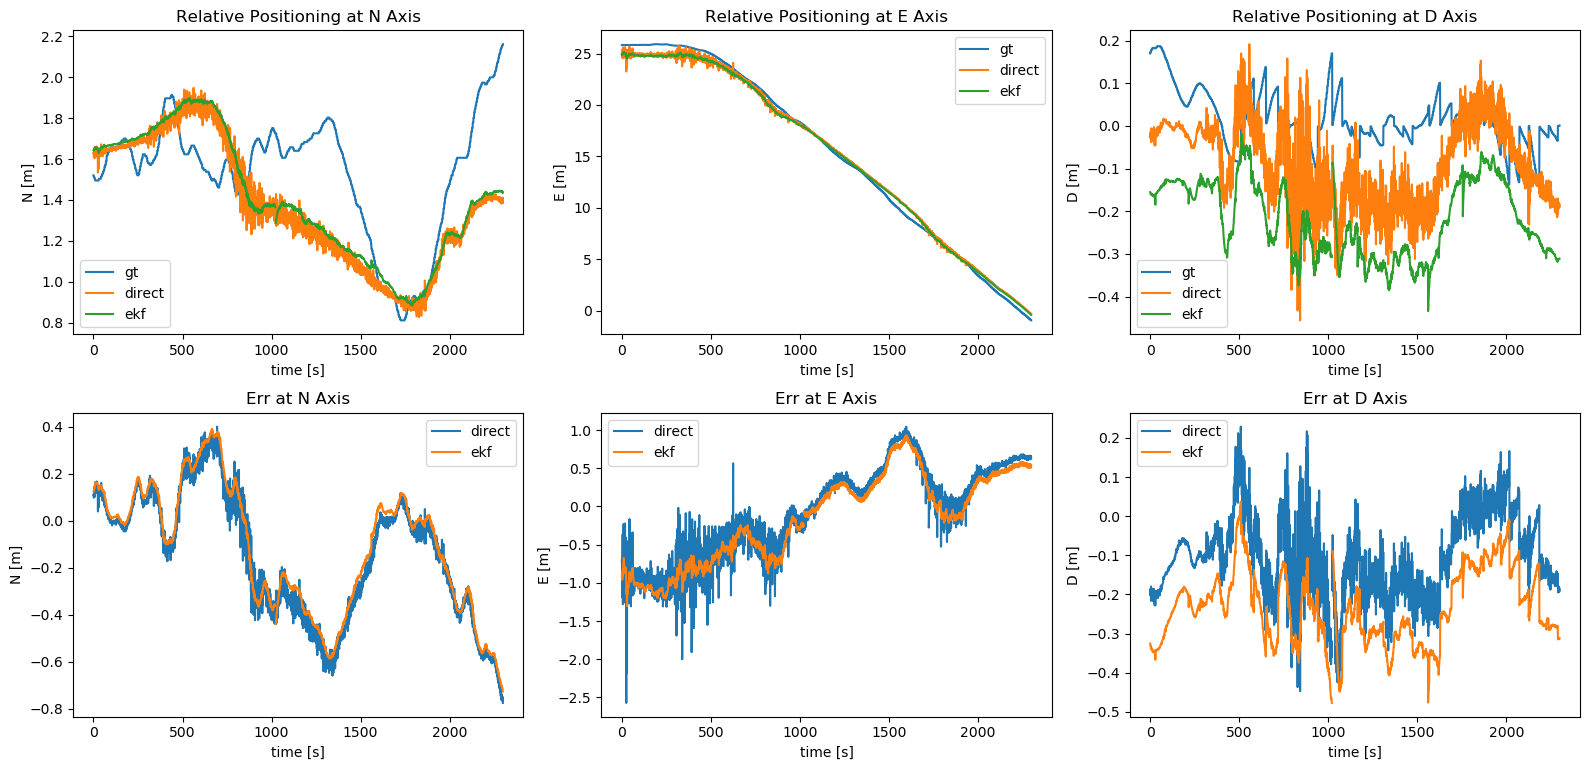

In [102]:
pose_ekf = np.array(ekf_X_list)[:,:3]

fig, axs = plt.subplots(2, 3,figsize=(16, 7.8))
LABEL = "NED"
for i in range(3):
    axs[0,i].plot(pose_gt_fix[start_idx:end_idx,i],label="gt")
    axs[0,i].plot(pose_direct_fix[start_idx:end_idx,i],label="direct")
    axs[0,i].plot(pose_ekf[start_idx:end_idx,i],label="ekf")

    axs[0,i].set_title(f"Relative Positioning at {LABEL[i]} Axis")
    axs[0,i].set_xlabel("time [s]")
    axs[0,i].set_ylabel(f"{LABEL[i]} [m]")
    # axs[0,i].ylim([0,300])
    axs[0,i].legend()
for i in range(3):
    # axs[1,i].plot(pose_gt_fix[start_idx:end_idx,i],label="gt")
    axs[1,i].plot(pose_direct_fix[start_idx:end_idx,i] - pose_gt_fix[start_idx:end_idx,i],label="direct")
    axs[1,i].plot(pose_ekf[start_idx:end_idx,i] - pose_gt_fix[start_idx:end_idx,i],label="ekf")

    axs[1,i].set_title(f"Err at {LABEL[i]} Axis")
    axs[1,i].set_xlabel("time [s]")
    axs[1,i].set_ylabel(f"{LABEL[i]} [m]")
    axs[1,i].legend()
fig.tight_layout()
plt.savefig("real-pose.pdf")